In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install xlrd

In [3]:
df = pd.read_csv("/Users/margaritafisher/Documents/ITBA/2024 2do Cuatrimestre/Análisis Predictivo Avanzado/daily-website-visitors.csv")

In [4]:
df.dtypes

Row                   int64
Day                  object
Day.Of.Week           int64
Date                 object
Page.Loads           object
Unique.Visits        object
First.Time.Visits    object
Returning.Visits     object
dtype: object

In [5]:
df

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236
...,...,...,...,...,...,...,...,...
2162,2163,Saturday,7,8/15/2020,"2,221","1,696","1,373",323
2163,2164,Sunday,1,8/16/2020,"2,724","2,037","1,686",351
2164,2165,Monday,2,8/17/2020,"3,456","2,638","2,181",457
2165,2166,Tuesday,3,8/18/2020,"3,581","2,683","2,184",499


In [6]:
df["Page.Loads"] = df['Page.Loads'].replace(',', '', regex=True)
df["Page.Loads"] = df["Page.Loads"].astype(int)
df["PageLoads"] = df["Page.Loads"]
df = df.drop(columns=["Page.Loads","Returning.Visits","First.Time.Visits","Unique.Visits"])

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.dtypes

Row                     int64
Day                    object
Day.Of.Week             int64
Date           datetime64[ns]
PageLoads               int64
dtype: object

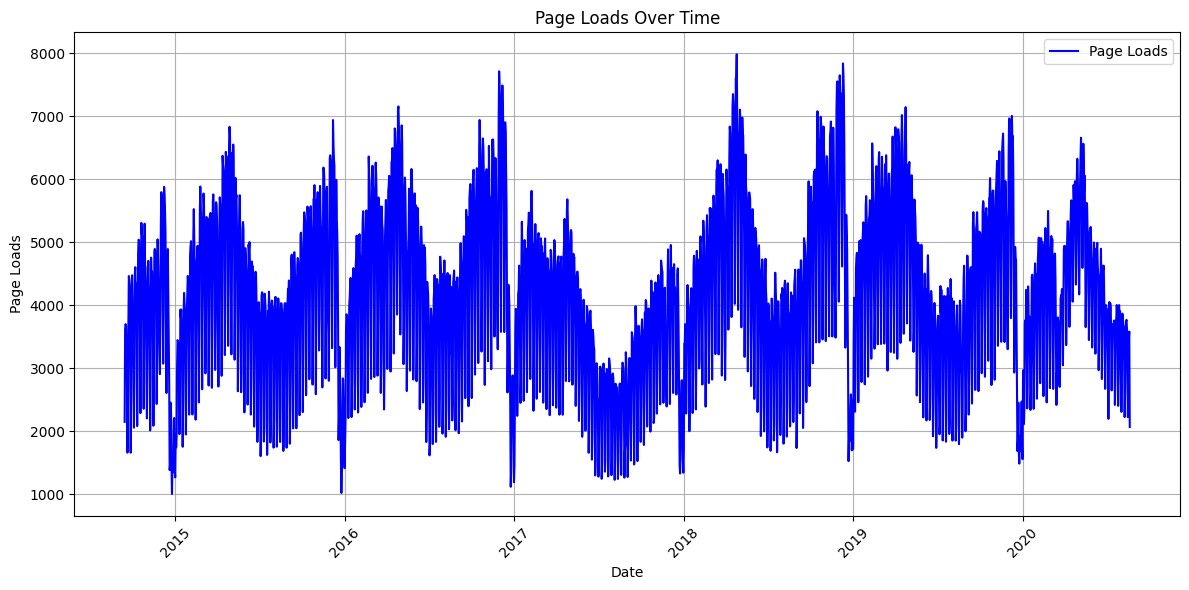

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['PageLoads'], linestyle='-', color='b', label='Page Loads')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('Page Loads Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
dfgb = df.groupby('Date')['PageLoads'].sum().reset_index()
dfgb = dfgb.set_index('Date')
y = dfgb['PageLoads'].resample('MS').mean()

<Figure size 1600x1000 with 0 Axes>

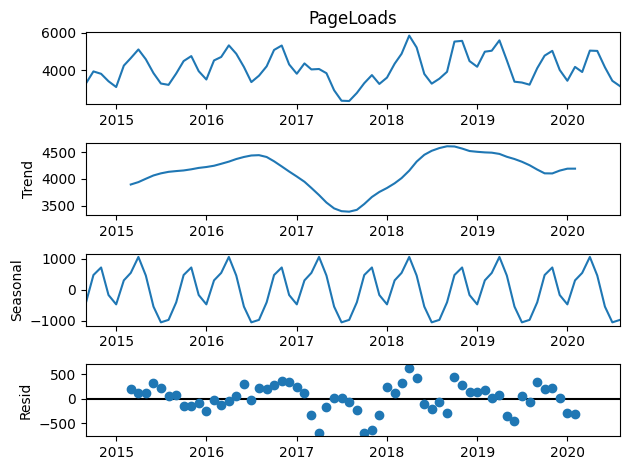

In [11]:
import statsmodels.api as sm
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [12]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [13]:
# Agrupamos por mes con la media de cargas que tuvo la pagina

df_page_loads = dfgb['PageLoads'].resample('MS').mean().to_frame()
df_page_loads.head()

,PageLoads
Date,
2014-09-01,3297.176471
2014-10-01,3934.935484
2014-11-01,3806.333333
2014-12-01,3407.000000
2015-01-01,3099.258065


<Axes: xlabel='Date'>

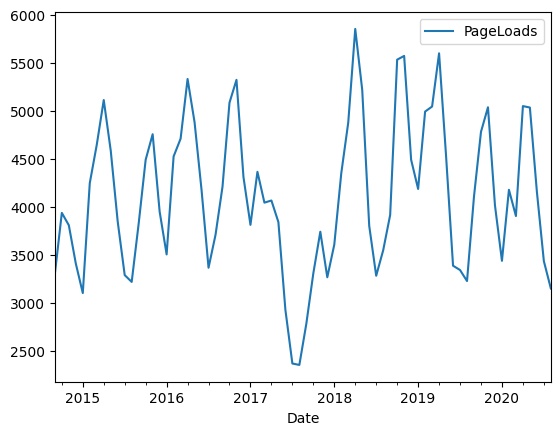

In [14]:
df_page_loads.plot()

In [15]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_page_loads, test_size=12, random_state=42, shuffle=False)

In [16]:
df_test

,PageLoads
Date,
2019-09-01,4107.100000
2019-10-01,4779.870968
2019-11-01,5035.933333
2019-12-01,4013.516129
2020-01-01,3435.225806
2020-02-01,4176.000000
2020-03-01,3902.354839
2020-04-01,5048.066667
2020-05-01,5032.935484


In [17]:
# Se le asigna el shift a cada uno, el cual es el valor del periodo anterior

df_train["PageLoadsShift1"] = df_train["PageLoads"].shift()
df_train["PageLoadsShift1"].fillna(method='bfill', inplace=True)
df_train.head(3)

,PageLoads,PageLoadsShift1
Date,,
2014-09-01,3297.176471,3297.176471
2014-10-01,3934.935484,3297.176471
2014-11-01,3806.333333,3934.935484


In [18]:
df_test["PageLoadsShift1"] = df_test["PageLoads"].shift()
df_test["PageLoadsShift1"].fillna(method='bfill', inplace=True)
# Le asignamos al primer valor de test el ultimo de train
# df_test.loc[df_test.index[0], "PageLoadsShift1"] = df_train["PageLoadsShift1"].iloc[-1]
df_test.head(3)

,PageLoads,PageLoadsShift1
Date,,
2019-09-01,4107.100000,4107.100000
2019-10-01,4779.870968,4107.100000
2019-11-01,5035.933333,4779.870968


<Axes: xlabel='Date'>

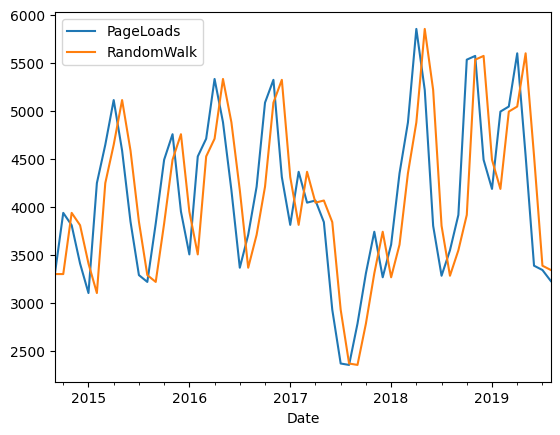

In [19]:
df_train["RandomWalk"] = df_train.PageLoadsShift1
df_train.plot(kind="line", y = ["PageLoads", "RandomWalk"])

In [20]:
df_test["RandomWalk"] = pd.Series(df_train["PageLoads"][-1], index=df_test.index)

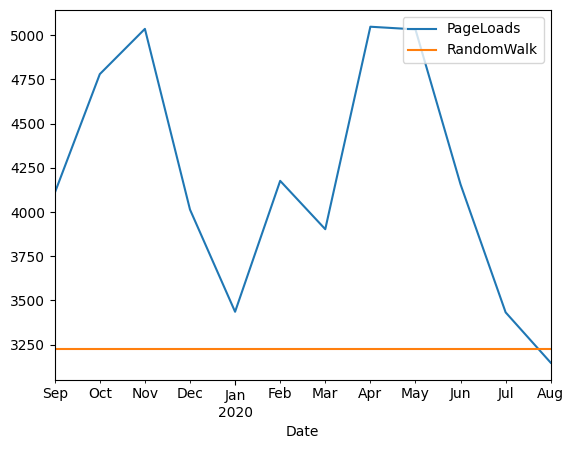

In [21]:
df_test.plot(kind="line", y = ["PageLoads", "RandomWalk"]);

In [22]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Random Walk"
df_Results.loc[0, "RMSE"] = RMSE(df_test.RandomWalk, df_test["PageLoads"])
df_Results

,Model,RMSE
0,Random Walk,1155.740079


In [23]:
model_mean_pred = df_train['PageLoads'].mean()
model_mean_pred

4096.121835009124

In [24]:
df_train_mc = df_train.copy()
df_train_mc['Mean'] = model_mean_pred

df_test_mc = df_test.copy()
df_test_mc['Mean'] = model_mean_pred

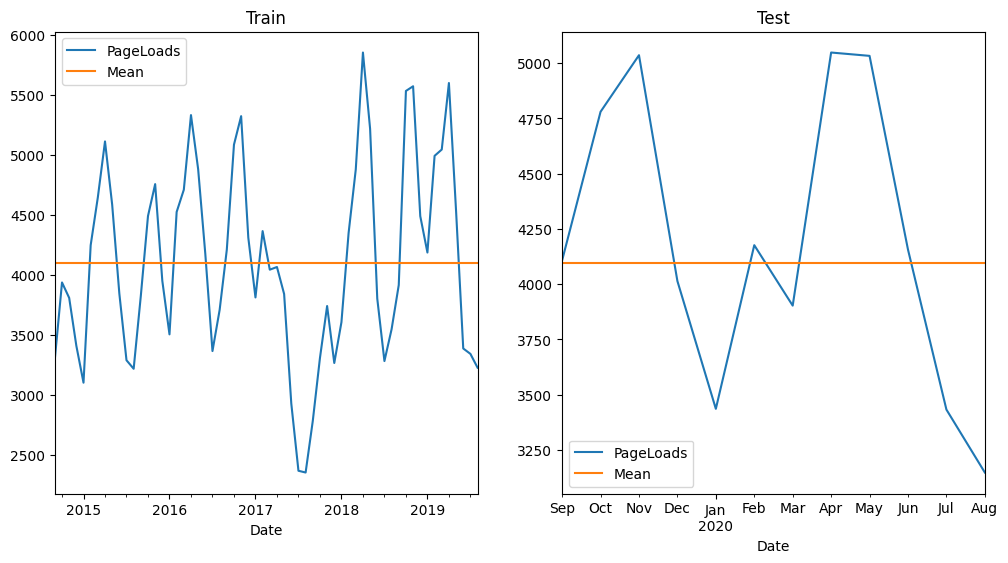

In [25]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train_mc.plot(ax=axes[0], y = ["PageLoads","Mean"],title='Train')
df_test_mc.plot(ax=axes[1],y = ["PageLoads","Mean"], title='Test')
plt.show()

In [26]:
df_Results.loc[1, "Model"] = "Mean"
df_Results.loc[1, "RMSE"] = RMSE(df_test_mc.Mean, df_test_mc["PageLoads"])
df_Results.head()

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917


In [27]:
df_page_loads["timeIndex"] = pd.Series(np.arange(len(df_page_loads['PageLoads'])), index=df_page_loads.index)
df_page_loads.timeIndex.head(3)

Date
2014-09-01    0
2014-10-01    1
2014-11-01    2
Freq: MS, Name: timeIndex, dtype: int64

In [28]:
df_train, df_test = train_test_split(df_page_loads, test_size=12, random_state=42, shuffle=False)

In [29]:
import statsmodels.api as sm
sm.OLS.from_formula

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

In [30]:
import statsmodels.formula.api as smf
model_linear = smf.ols(formula='PageLoads ~ timeIndex', data = df_train).fit()

In [31]:
# No hay que predecir con train? lo cambio
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

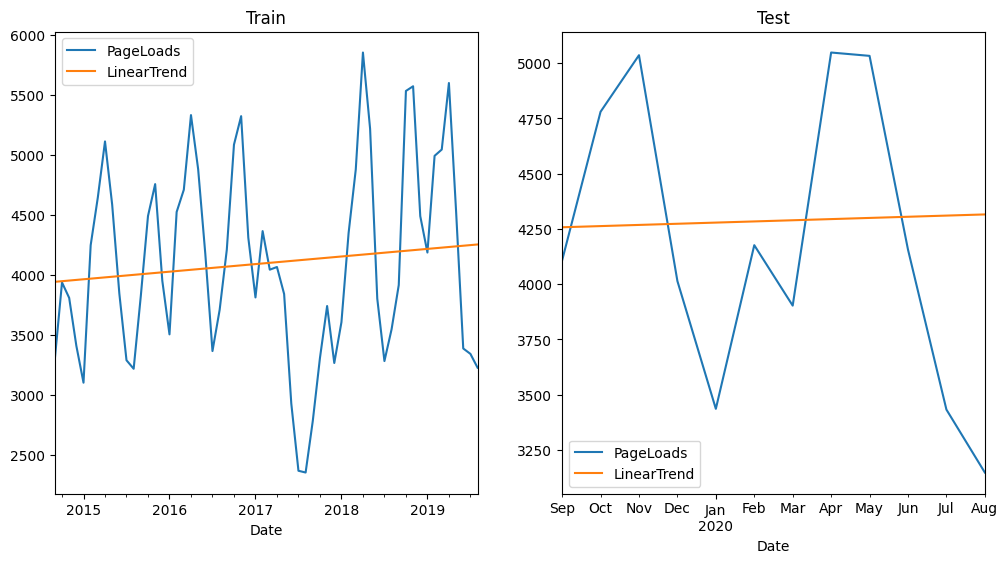

In [32]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["PageLoads","LinearTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["PageLoads","LinearTrend"],ax=axes[1],title='Test');
plt.show()

In [33]:
df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = RMSE(df_test.LinearTrend, df_test.PageLoads)
df_Results.head()

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015


In [34]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PageLoads   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7397
Date:                Thu, 28 Nov 2024   Prob (F-statistic):              0.393
Time:                        00:00:53   Log-Likelihood:                -486.92
No. Observations:                  60   AIC:                             977.8
Df Residuals:                      58   BIC:                             982.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3940.4120    209.939     18.769      0.000    3520.174    4360.650
timeIndex      5.2783      6.137      0.860      0.393      -7.007      17.563
==============================================================================
Omnibus:                        1.311   Durbin-Watson:                   0.639
Prob(Omnibus):                  0.519   Jarque-Bera (JB):                1.042
Skew:                           0.026   Prob(JB):                        0.594
Kurtosis:                       2.356   Cond. No.                         67.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
df_page_loads["timeIndex_sq"] = df_page_loads["timeIndex"]**2
df_page_loads.timeIndex_sq.head(3)

Date
2014-09-01    0
2014-10-01    1
2014-11-01    4
Freq: MS, Name: timeIndex_sq, dtype: int64

In [36]:
df_train, df_test = train_test_split(df_page_loads, test_size=12, random_state=42, shuffle=False)

In [37]:
model_quadratic = smf.ols('PageLoads ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [38]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex","timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex","timeIndex_sq"]])

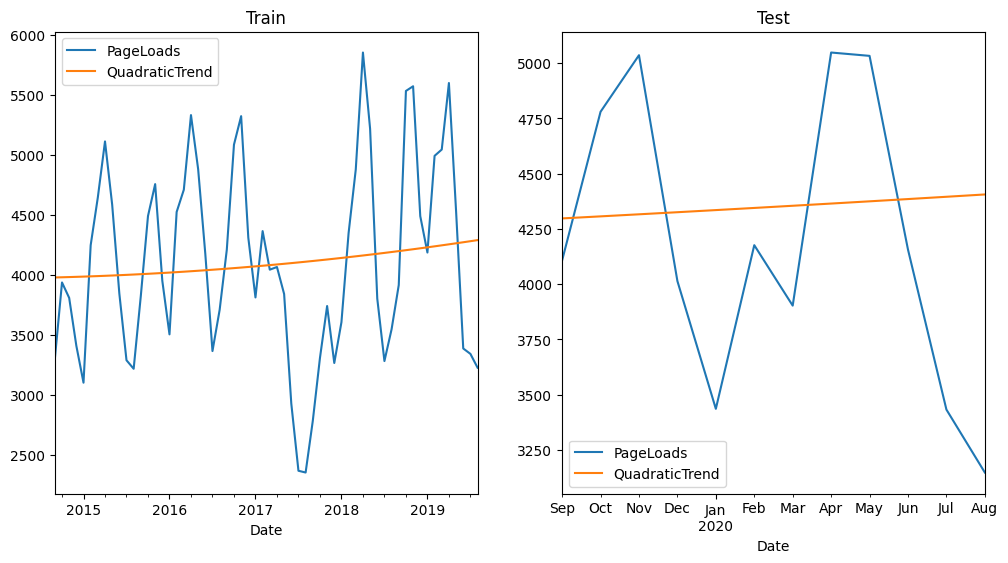

In [39]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["PageLoads","QuadraticTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["PageLoads","QuadraticTrend"],ax=axes[1],title='Test');
plt.show()

In [40]:
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = RMSE(df_test.QuadraticTrend, df_test.PageLoads)
df_Results.head()

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015
3,QuadraticTrend,669.797155


In [41]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PageLoads   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.3763
Date:                Thu, 28 Nov 2024   Prob (F-statistic):              0.688
Time:                        00:00:53   Log-Likelihood:                -486.90
No. Observations:                  60   AIC:                             979.8
Df Residuals:                      57   BIC:                             986.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3976.6643    311.138     12.781      0.000    3353.622    4599.707
timeIndex        1.5281     24.384      0.063      0.950     -47.299      50.356
timeIndex_sq     0.0636      0.400      0.159      0.874      -0.737       0.864
==============================================================================
Omnibus:                        1.489   Durbin-Watson:                   0.640
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.120
Skew:                           0.033   Prob(JB):                        0.571
Kurtosis:                       2.334   Cond. No.                     4.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
df_train['log_PageLoads'] = np.log(df_train['PageLoads'])
df_test['log_PageLoads'] = np.log(df_test['PageLoads'])

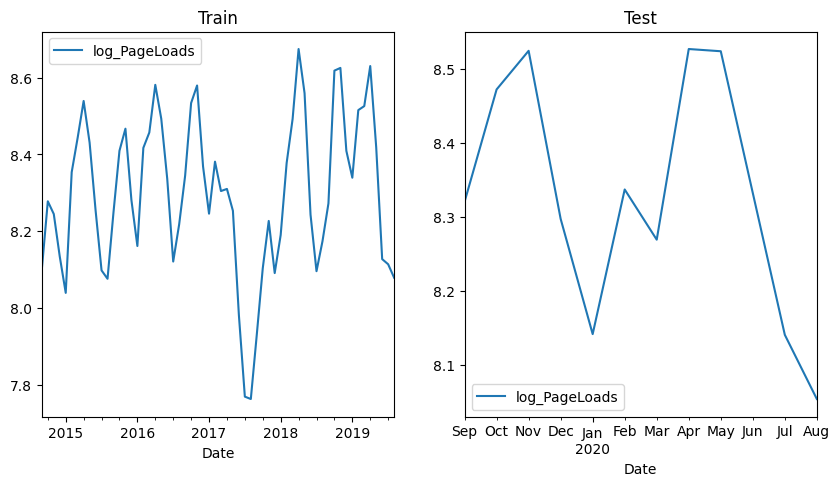

In [43]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["log_PageLoads"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["log_PageLoads"],ax=axes[1],title='Test');
plt.show()

In [44]:
model_log = smf.ols('log_PageLoads ~ timeIndex', data = df_train).fit()

In [45]:
df_train["LogTrend"] = model_log.predict(df_train[["timeIndex"]])
df_test["LogTrend"] = model_log.predict(df_test[["timeIndex"]])

In [46]:
df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

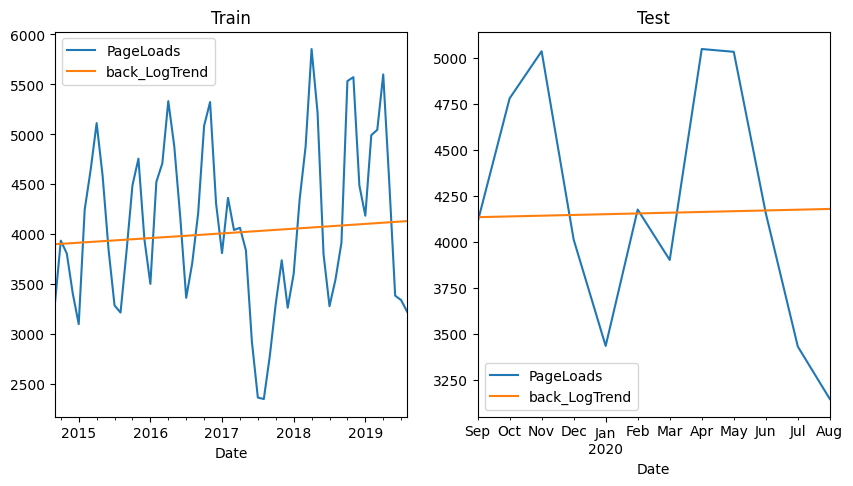

In [47]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["PageLoads","back_LogTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["PageLoads","back_LogTrend"],ax=axes[1],title='Test');
plt.show()

In [48]:
df_Results.loc[4, "Model"] = "back_LogTrend"
df_Results.loc[4, "RMSE"] = RMSE(df_test.back_LogTrend, df_test.PageLoads)
df_Results.head()

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015
3,QuadraticTrend,669.797155
4,back_LogTrend,642.756971


In [49]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_PageLoads   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.3993
Date:                Thu, 28 Nov 2024   Prob (F-statistic):              0.530
Time:                        00:00:54   Log-Likelihood:                 10.221
No. Observations:                  60   AIC:                            -16.44
Df Residuals:                      58   BIC:                            -12.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2685      0.053    156.221      0.000       8.163       8.374
timeIndex      0.0010      0.002      0.632      0.530      -0.002       0.004
==============================================================================
Omnibus:                        2.016   Durbin-Watson:                   0.583
Prob(Omnibus):                  0.365   Jarque-Bera (JB):                1.793
Skew:                          -0.418   Prob(JB):                        0.408
Kurtosis:                       2.869   Cond. No.                         67.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]

In [51]:
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])

In [52]:
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

In [53]:
df_train.head(4)

,PageLoads,timeIndex,timeIndex_sq,QuadraticTrend,log_PageLoads,LogTrend,back_LogTrend,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,,,,,,
2014-09-01,3297.176471,0,0,3976.664287,8.100822,8.268500,3899.094216,Sep,False,False,False,False,False,False,False,False,False,False,False,True
2014-10-01,3934.935484,1,1,3978.255915,8.277650,8.269477,3902.908102,Oct,False,False,False,False,False,False,False,False,False,False,True,False
2014-11-01,3806.333333,2,4,3979.974670,8.244422,8.270455,3906.725719,Nov,False,False,False,False,False,False,False,False,False,True,False,False
2014-12-01,3407.000000,3,9,3981.820551,8.133587,8.271433,3910.547070,Dec,False,False,True,False,False,False,False,False,False,False,False,False


In [54]:
model_log_est = smf.ols('log_PageLoads ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [55]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

In [56]:
df_test

,PageLoads,timeIndex,timeIndex_sq,QuadraticTrend,log_PageLoads,LogTrend,back_LogTrend,month,Apr,Aug,...,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-01,4107.100000,60,3600,4297.175998,8.320472,8.327160,4134.657090,Sep,False,False,...,False,False,False,False,False,False,False,False,True,8.237717
2019-10-01,4779.870968,61,3721,4306.395220,8.472169,8.328137,4138.701391,Oct,False,False,...,False,False,False,False,False,False,False,True,False,8.446776
2019-11-01,5035.933333,62,3844,4315.741569,8.524354,8.329115,4142.749649,Nov,False,False,...,False,False,False,False,False,False,True,False,False,8.486855
2019-12-01,4013.516129,63,3969,4325.215044,8.297423,8.330093,4146.801866,Dec,False,False,...,False,False,False,False,False,False,False,False,False,8.314885
2020-01-01,3435.225806,64,4096,4334.815646,8.141838,8.331070,4150.858047,Jan,False,False,...,False,True,False,False,False,False,False,False,False,8.253188
2020-02-01,4176.000000,65,4225,4344.543375,8.337109,8.332048,4154.918195,Feb,False,False,...,True,False,False,False,False,False,False,False,False,8.467187
2020-03-01,3902.354839,66,4356,4354.398230,8.269335,8.333026,4158.982315,Mar,False,False,...,False,False,False,False,True,False,False,False,False,8.502950
2020-04-01,5048.066667,67,4489,4364.380211,8.526761,8.334003,4163.050410,Apr,True,False,...,False,False,False,False,False,False,False,False,False,8.605330
2020-05-01,5032.935484,68,4624,4374.489320,8.523759,8.334981,4167.122485,May,False,False,...,False,False,False,False,False,True,False,False,False,8.489141


In [57]:
df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

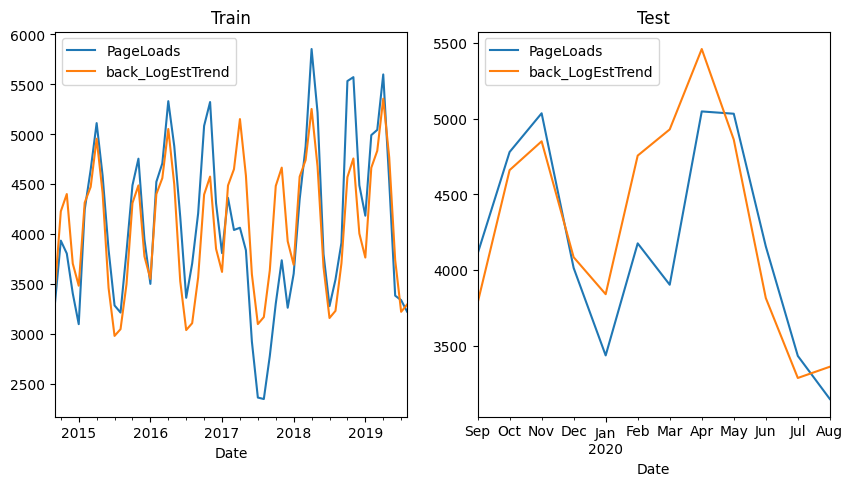

In [58]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["PageLoads","back_LogEstTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["PageLoads","back_LogEstTrend"],ax=axes[1],title='Test');
plt.show()

In [59]:
df_Results.loc[5, "Model"] = "back_LogEstTrend"
df_Results.loc[5, "RMSE"] = RMSE(df_test.back_LogEstTrend, df_test.PageLoads)
df_Results

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015
3,QuadraticTrend,669.797155
4,back_LogTrend,642.756971
5,back_LogEstTrend,418.129685


In [60]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_PageLoads   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     6.240
Date:                Thu, 28 Nov 2024   Prob (F-statistic):           2.03e-06
Time:                        00:00:54   Log-Likelihood:                 38.603
No. Observations:                  60   AIC:                            -51.21
Df Residuals:                      47   BIC:                            -23.98
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.6150      0.034    221.783      0.000       7.546       7.684
Apr[T.True]     0.8818      0.062     14.299      0.000       0.758       1.006
Aug[T.True]     0.3898      0.062      6.276      0.000       0.265       0.515
Dec[T.True]     0.5979      0.062      9.716      0.000       0.474       0.722
Feb[T.True]     0.7469      0.062     12.133      0.000       0.623       0.871
Jan[T.True]     0.5345      0.062      8.686      0.000       0.411       0.658
Jul[T.True]     0.3691      0.062      5.955      0.000       0.244       0.494
Jun[T.True]     0.5199      0.062      8.404      0.000       0.395       0.644
Mar[T.True]     0.7811      0.062     12.678      0.000       0.657       0.905
May[T.True]     0.7640      0.062     12.372      0.000       0.640       0.888
Nov[T.True]     0.7714      0.062     12.534      0.000       0.648       0.895
Oct[T.True]     0.7330      0.062     11.903      0.000       0.609       0.857
Sep[T.True]     0.5256      0.062      8.527      0.000       0.402       0.650
timeIndex       0.0016      0.001      1.482      0.145      -0.001       0.004
==============================================================================
Omnibus:                        6.980   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.109
Skew:                          -0.840   Prob(JB):                       0.0286
Kurtosis:                       2.852   Cond. No.                     2.47e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
df_page_loads["sma_5"] = df_page_loads.PageLoads.rolling(5,min_periods=1).mean()
df_page_loads["sma_15"] = df_page_loads.PageLoads.rolling(15,min_periods=1).mean()

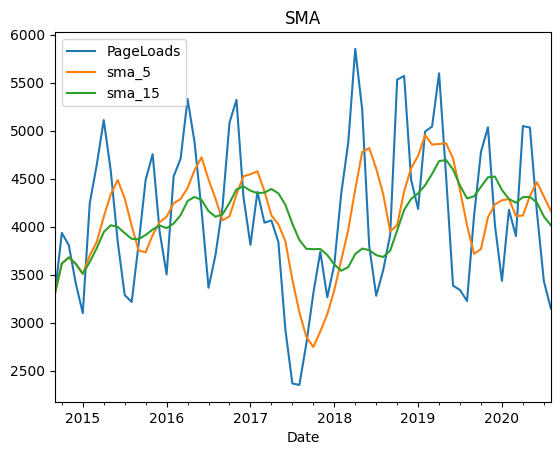

In [62]:
df_page_loads.plot(kind = "line", y = ["PageLoads","sma_5","sma_15"],title='SMA');

In [63]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model_exp_smoothing_05 = SimpleExpSmoothing(df_train.PageLoads).fit(smoothing_level=0.5,optimized=False)

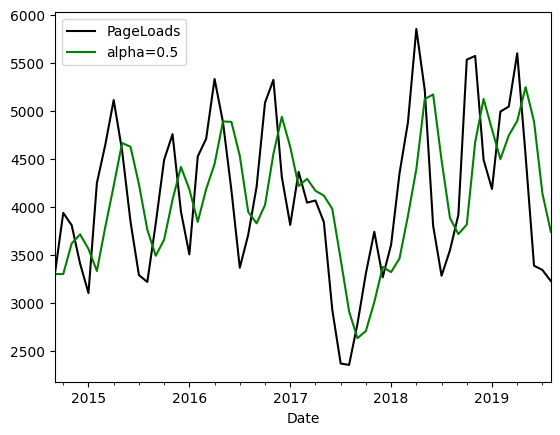

In [64]:
df_train.plot(kind = "line", y = "PageLoads",color='black')
model_exp_smoothing_05.fittedvalues.plot(label="alpha=0.5",color='g');
plt.legend();

In [65]:
df_test["Simple_Smoothing_05"] = model_exp_smoothing_05.forecast(len(df_test))

In [66]:
model_RMSE_05 = RMSE(df_test["Simple_Smoothing_05"], df_test.PageLoads)

In [67]:
df_Results.loc[6, "Model"] = "Simple Smoothing a=0.5"
df_Results.loc[6, "RMSE"] = model_RMSE_05
df_Results

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015
3,QuadraticTrend,669.797155
4,back_LogTrend,642.756971
5,back_LogEstTrend,418.129685
6,Simple Smoothing a=0.5,952.071637


Estudio de estacionareidad

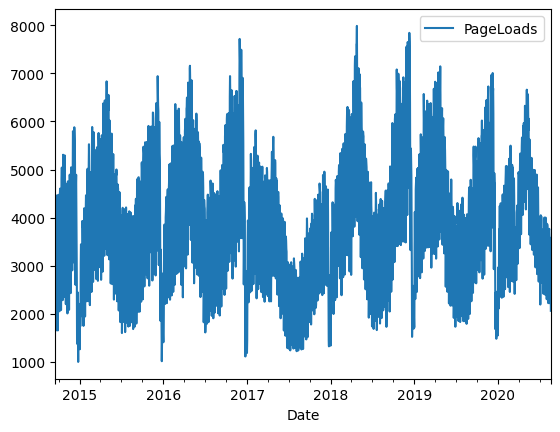

In [68]:
dfgb.plot()
plt.show()

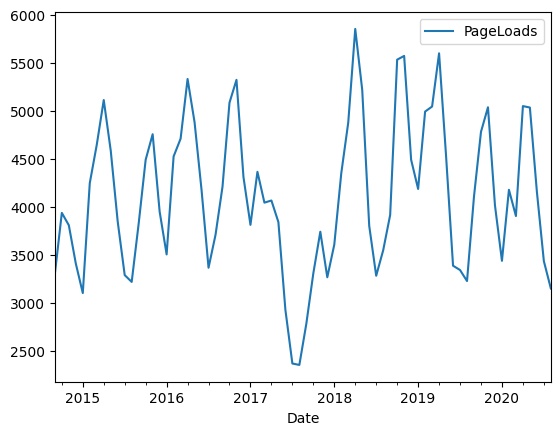

In [69]:
df_page_loads = dfgb['PageLoads'].resample('MS').mean().to_frame()
df_page_loads.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

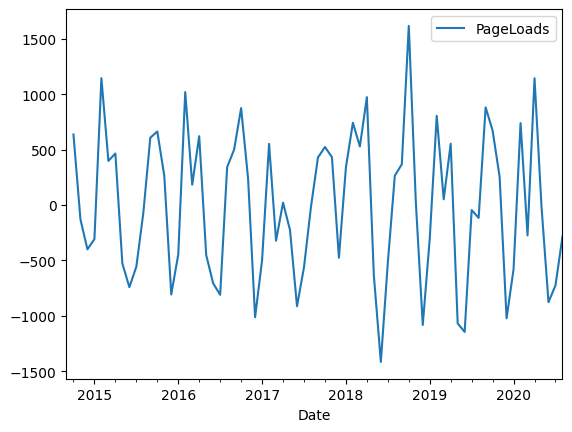

In [70]:
df_page_loads.diff().plot()
plt.show

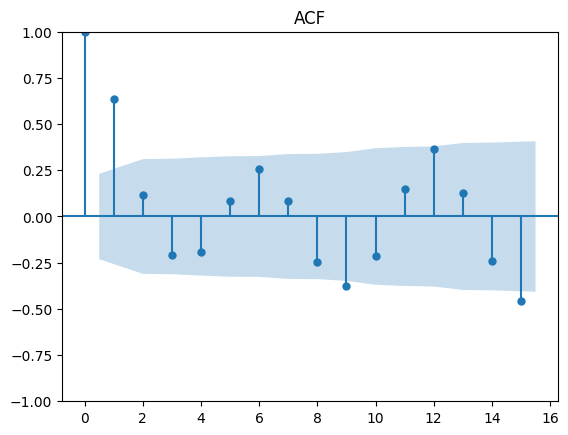

In [71]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

smt.graphics.plot_acf(df_page_loads, lags=15,title='ACF')
plt.show()

Vemos que desciende a cero rapidamente, lo cual puede indicar que es una serie estacionaria

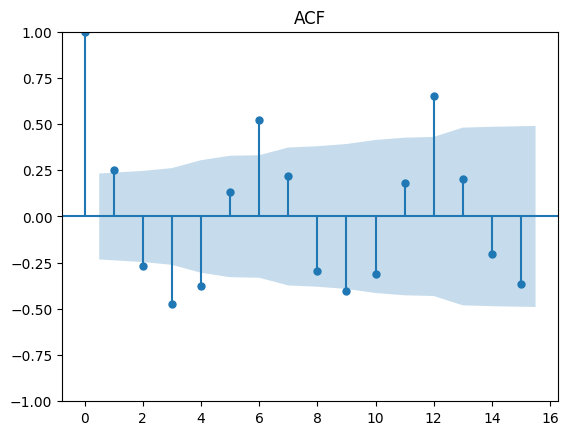

In [72]:
smt.graphics.plot_acf(df_page_loads.diff()[1:], lags=15,title='ACF')
plt.show()

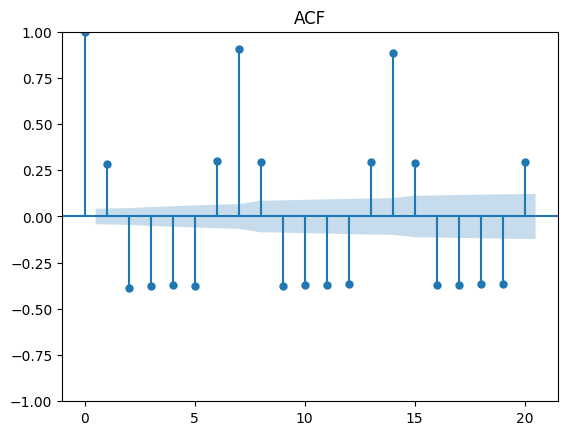

In [73]:
smt.graphics.plot_acf(dfgb.diff()[1:], lags=20,title='ACF')
plt.show()

Vemos que sigue cierto patron ¿que significa?

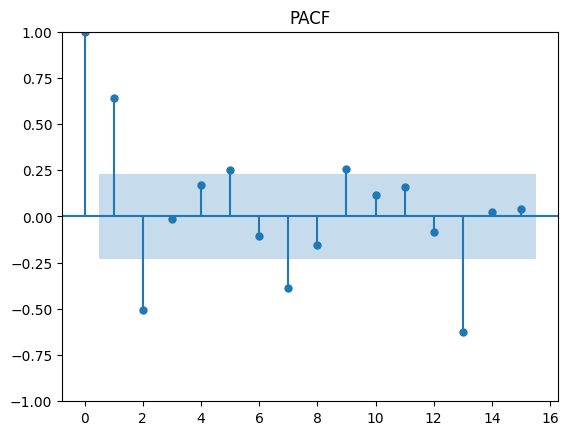

In [74]:
smt.graphics.plot_pacf(df_page_loads, lags=15,title='PACF')
plt.show();

In [75]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_page_loads); 
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.165892
p-value: 0.022046
Valor crítico 1%: -3.55
Valor crítico 5%: -2.91
Valor crítico 10%: -2.59


In [76]:
result = adfuller(df_page_loads.diff()[1:]); print('ADF Statistic: %f' % result[0]); 
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))
#El p-valor es = 0, por lo tanto, la serie se convirtió en estacionaria!    

ADF Statistic: -2.229459
p-value: 0.195728
Valor crítico 1%: -3.55
Valor crítico 5%: -2.91
Valor crítico 10%: -2.59


El diff da peor que el normal, no hace falta hacerlo ya es estacionario el normal

In [77]:
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA = ARIMA(df_page_loads, order=(2,0,2))
results_ARIMA = model_ARIMA.fit()

In [78]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              PageLoads   No. Observations:                   72
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -549.019
Date:                Thu, 28 Nov 2024   AIC                           1110.039
Time:                        00:00:56   BIC                           1123.699
Sample:                    09-01-2014   HQIC                          1115.477
                         - 08-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4109.9858    110.235     37.284      0.000    3893.929    4326.042
ar.L1          0.9621      0.099      9.730      0.000       0.768       1.156
ar.L2         -0.8301      0.099     -8.361      0.0

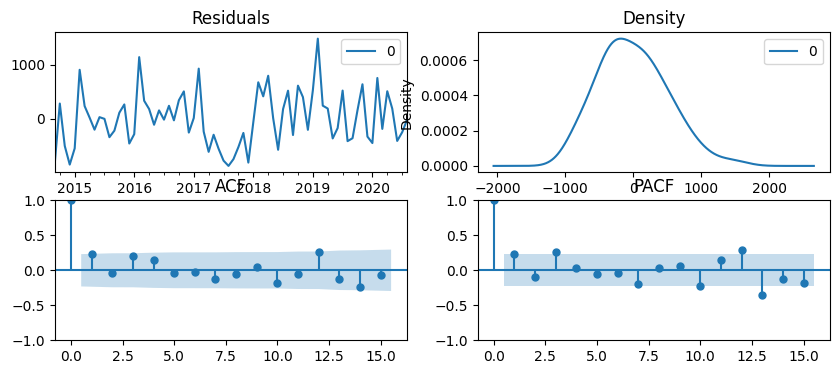

In [79]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2,figsize=(10,4))

residuals.plot(title="Residuals", ax=axes[0,0]); 
residuals.plot(kind='kde', title='Density', ax=axes[0,1])
smt.graphics.plot_acf(residuals, lags=15,ax=axes[1,0],title='ACF'); 
smt.graphics.plot_pacf(residuals, lags=15,ax=axes[1,1],title='PACF')
plt.show()

predicted=3969.077929, expected=4107.100000
predicted=4447.704651, expected=4779.870968
predicted=4766.859775, expected=5035.933333
predicted=4673.258346, expected=4013.516129
predicted=3573.337401, expected=3435.225806
predicted=3232.940590, expected=4176.000000
predicted=4550.006823, expected=3902.354839
predicted=4410.938846, expected=5048.066667
predicted=4857.085862, expected=5032.935484
predicted=4633.466058, expected=4156.100000
predicted=3710.965105, expected=3431.838710
predicted=3177.089796, expected=3146.894737
Test RMSE: 475.087


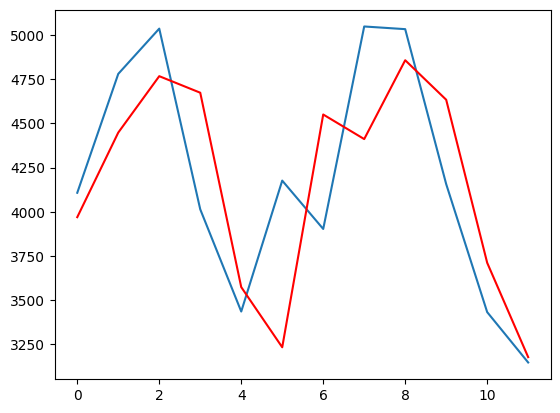

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

history = [x for x in df_train['PageLoads']]
test = [x for x in df_test['PageLoads']]
predictions = list()

#Nos movemos de a un lag por vez y entrenamos el modelo sucesivas veces, a partir de la historia disponible
for t in range(len(test)):
	model = ARIMA(history, order=(2,0,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [81]:
df_Results.loc[7, "Model"] = "ARIMA"
df_Results.loc[7, "RMSE"] = sqrt(mean_squared_error(test, predictions))
df_Results

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015
3,QuadraticTrend,669.797155
4,back_LogTrend,642.756971
5,back_LogEstTrend,418.129685
6,Simple Smoothing a=0.5,952.071637
7,ARIMA,475.086876


In [82]:
 !pip install prophet

In [83]:
df_full = df
df_full.head()

,Row,Day,Day.Of.Week,Date,PageLoads
0,1,Sunday,1,2014-09-14,2146
1,2,Monday,2,2014-09-15,3621
2,3,Tuesday,3,2014-09-16,3698
3,4,Wednesday,4,2014-09-17,3667
4,5,Thursday,5,2014-09-18,3316


In [84]:
#Debemos renombrar las columnas de fecha y valor a "ds" e "y"
df_full.rename(columns={'Date':'ds','PageLoads':'y'},inplace=True)

In [85]:
df_full = df_full[["ds","y"]]

In [86]:
df_full

,ds,y
0,2014-09-14,2146
1,2014-09-15,3621
2,2014-09-16,3698
3,2014-09-17,3667
4,2014-09-18,3316
...,...,...
2162,2020-08-15,2221
2163,2020-08-16,2724
2164,2020-08-17,3456
2165,2020-08-18,3581


In [87]:
df_full["month_year"] = df_full["ds"].dt.to_period("M")

# Filtrar solo los primeros días del mes
first_days = df_full[df_full["ds"].dt.day == 1]

# Calcular el promedio para cada mes
average_per_month = df_full.groupby("month_year")["y"].mean().reset_index()

average_per_month.rename(columns={'month_year':'ds'},inplace=True)

average_per_month

,ds,y
0,2014-09,3297.176471
1,2014-10,3934.935484
2,2014-11,3806.333333
3,2014-12,3407.000000
4,2015-01,3099.258065
...,...,...
67,2020-04,5048.066667
68,2020-05,5032.935484
69,2020-06,4156.100000
70,2020-07,3431.838710


In [88]:
df_train_pro = average_per_month.loc[:59,]
df_test_pro = average_per_month.loc[60:,]

In [89]:
# Convertir la columna 'ds' de Period a Timestamp
df_train_pro["ds"] = df_train_pro["ds"].dt.to_timestamp()
df_test_pro["ds"] = df_test_pro["ds"].dt.to_timestamp()

In [90]:
from prophet import Prophet
model = Prophet()
model.fit(df_train_pro)

00:00:58 - cmdstanpy - INFO - Chain [1] start processing
00:00:58 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
# Create a future dataframe
future = model.make_future_dataframe(periods=12)
future

,ds
0,2014-09-01
1,2014-10-01
2,2014-11-01
3,2014-12-01
4,2015-01-01
...,...
67,2019-08-09
68,2019-08-10
69,2019-08-11
70,2019-08-12


In [92]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2019-08-09,4494.911604,3830.506691,5107.190610
68,2019-08-10,4651.007961,4046.833304,5283.667505
69,2019-08-11,4802.094091,4197.193989,5431.776537
70,2019-08-12,4945.074961,4297.597322,5555.376057
71,2019-08-13,5076.828871,4415.543365,5728.811585


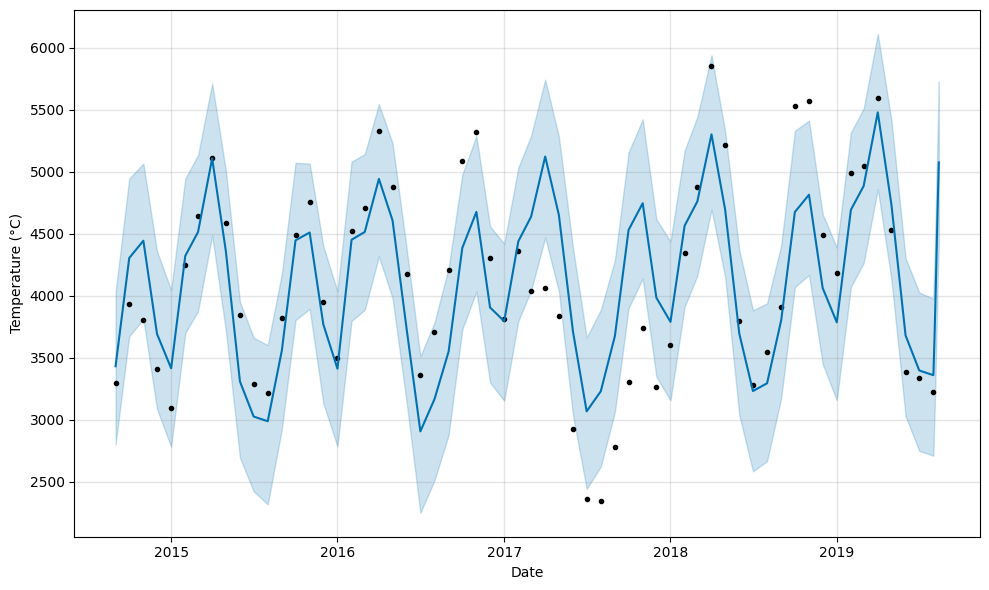

In [93]:
# Visualize the predictions
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

In [94]:
forecast = model.predict(df_test_pro)

In [95]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-01,4314.534546,3309.645023,4631.229594,4314.533755,4314.535286,-382.894582,-382.894582,-382.894582,-382.894582,-382.894582,-382.894582,0.0,0.0,0.0,3931.639964
1,2019-10-01,4322.187898,4178.592729,5480.210284,4322.185192,4322.190608,497.183269,497.183269,497.183269,497.183269,497.183269,497.183269,0.0,0.0,0.0,4819.371167
2,2019-11-01,4330.096362,4289.405324,5537.362868,4330.090126,4330.102136,552.266232,552.266232,552.266232,552.266232,552.266232,552.266232,0.0,0.0,0.0,4882.362594
3,2019-12-01,4337.749714,3487.720397,4777.841215,4337.739857,4337.759162,-195.946054,-195.946054,-195.946054,-195.946054,-195.946054,-195.946054,0.0,0.0,0.0,4141.803661
4,2020-01-01,4345.658178,3128.435120,4423.944799,4345.643666,4345.671651,-560.934147,-560.934147,-560.934147,-560.934147,-560.934147,-560.934147,0.0,0.0,0.0,3784.724031
5,2020-02-01,4353.566642,4207.136131,5466.797889,4353.547338,4353.585068,470.690794,470.690794,470.690794,470.690794,470.690794,470.690794,0.0,0.0,0.0,4824.257436
6,2020-03-01,4360.964883,4277.863973,5532.876935,4360.940578,4360.987789,526.262335,526.262335,526.262335,526.262335,526.262335,526.262335,0.0,0.0,0.0,4887.227218
7,2020-04-01,4368.873347,4675.681151,5985.477740,4368.844229,4368.901261,946.065334,946.065334,946.065334,946.065334,946.065334,946.065334,0.0,0.0,0.0,5314.938681
8,2020-05-01,4376.526699,4392.456209,5625.664487,4376.492122,4376.560239,602.971804,602.971804,602.971804,602.971804,602.971804,602.971804,0.0,0.0,0.0,4979.498503
9,2020-06-01,4384.435163,3487.391908,4735.202495,4384.392718,4384.475252,-283.341862,-283.341862,-283.341862,-283.341862,-283.341862,-283.341862,0.0,0.0,0.0,4101.093302


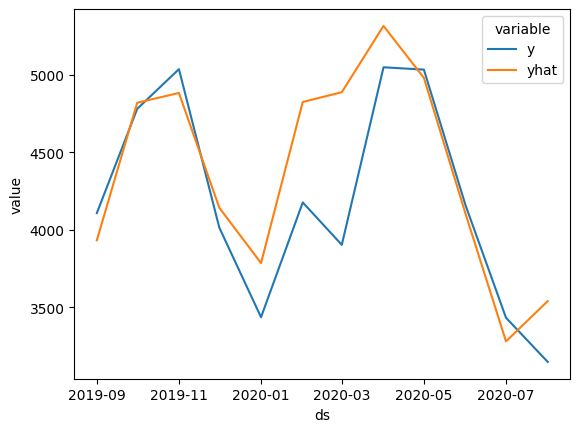

In [96]:
import seaborn as sns
aux=df_test_pro.copy()
aux = aux.reset_index(drop=True)
forecast = forecast.reset_index(drop=True)
# Copiar la columna yhat de forecast a df_test_pro
aux['yhat'] = forecast['yhat']
aux=pd.melt(aux, id_vars=['ds'], value_vars=['y','yhat'])

sns.lineplot(x=aux.ds,y=aux.value,hue=aux.variable)
plt.show()

In [97]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-01,4314.534546,3309.645023,4631.229594,4314.533755,4314.535286,-382.894582,-382.894582,-382.894582,-382.894582,-382.894582,-382.894582,0.0,0.0,0.0,3931.639964
1,2019-10-01,4322.187898,4178.592729,5480.210284,4322.185192,4322.190608,497.183269,497.183269,497.183269,497.183269,497.183269,497.183269,0.0,0.0,0.0,4819.371167
2,2019-11-01,4330.096362,4289.405324,5537.362868,4330.090126,4330.102136,552.266232,552.266232,552.266232,552.266232,552.266232,552.266232,0.0,0.0,0.0,4882.362594
3,2019-12-01,4337.749714,3487.720397,4777.841215,4337.739857,4337.759162,-195.946054,-195.946054,-195.946054,-195.946054,-195.946054,-195.946054,0.0,0.0,0.0,4141.803661
4,2020-01-01,4345.658178,3128.435120,4423.944799,4345.643666,4345.671651,-560.934147,-560.934147,-560.934147,-560.934147,-560.934147,-560.934147,0.0,0.0,0.0,3784.724031
5,2020-02-01,4353.566642,4207.136131,5466.797889,4353.547338,4353.585068,470.690794,470.690794,470.690794,470.690794,470.690794,470.690794,0.0,0.0,0.0,4824.257436
6,2020-03-01,4360.964883,4277.863973,5532.876935,4360.940578,4360.987789,526.262335,526.262335,526.262335,526.262335,526.262335,526.262335,0.0,0.0,0.0,4887.227218
7,2020-04-01,4368.873347,4675.681151,5985.477740,4368.844229,4368.901261,946.065334,946.065334,946.065334,946.065334,946.065334,946.065334,0.0,0.0,0.0,5314.938681
8,2020-05-01,4376.526699,4392.456209,5625.664487,4376.492122,4376.560239,602.971804,602.971804,602.971804,602.971804,602.971804,602.971804,0.0,0.0,0.0,4979.498503
9,2020-06-01,4384.435163,3487.391908,4735.202495,4384.392718,4384.475252,-283.341862,-283.341862,-283.341862,-283.341862,-283.341862,-283.341862,0.0,0.0,0.0,4101.093302


In [98]:
df_Results.loc[8, "Model"] = "ProphetFB"
df_Results.loc[8, "RMSE"] = sqrt(mean_squared_error(df_test_pro.y, forecast.yhat))
df_Results

,Model,RMSE
0,Random Walk,1155.740079
1,Mean,643.436917
2,LinearTrend,650.894015
3,QuadraticTrend,669.797155
4,back_LogTrend,642.756971
5,back_LogEstTrend,418.129685
6,Simple Smoothing a=0.5,952.071637
7,ARIMA,475.086876
8,ProphetFB,391.47901


In [99]:
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [103]:
from prophet.serialize import model_to_json

# Assuming `model` is your trained Prophet model
with open("prophet_model.json", "w") as f:
    f.write(model_to_json(model))
